notebook for decoding

In [6]:
from data_structures import PatientData
from sklearn.base import BaseEstimator
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from typing import Tuple
from sklearn.model_selection import train_test_split
import numpy as np
from dataclasses import dataclass
from typing import Dict, List
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
p566 = PatientData(pid='566')
p563 = PatientData(pid='563')

./Data/40m_act_24_S06E01_30fps_character_frames.csv
./Data/40m_act_24_S06E01_30fps_character_frames.csv


In [8]:
@dataclass
class DecodingResult:
    """Container for decoding results and metrics"""
    test_accuracy: float
    train_accuracy: float
    test_roc_auc: float
    train_roc_auc: float
    train_samples: Dict[str, int]  # Number of samples for each concept in training
    test_samples: Dict[str, int]   # Number of samples for each concept in testing
    predictions: np.ndarray
    true_labels: np.ndarray
    classifier: BaseEstimator
    data: Dict

In [9]:
class ConceptPairDataset():
    """
    Class to turn both concept bins - np.ndarrays shape (n_onsets, n_neurons) (each row is a response) into dataset with 

    2 methods - one with psuedopopulations

    
    """
    def __init__(self, patient_data: PatientData, concept_pair: Tuple[str, str], 
                 epoch: str, min_samples: int = 10):
        self.patient_data = patient_data
        self.c1, self.c2 = concept_pair
        self.epoch = epoch
        self.min_samples = min_samples

    def create_dataset_normal(self, test_size = 0.3):
        """
        Method to create dataset without pseudopops, liable to make unbalanced dataset

        Returns X_train, X_test, y_train, y_test, info: dict
        """
        c1_data, c2_data = self.patient_data.get_concept_data(c1=self.c1, c2=self.c2, epoch=self.epoch)

        print(f"c1 shape: {c1_data.shape[0]}, c2 shape: {c2_data.shape[0]}")

        if len(c1_data) < self.min_samples or len(c2_data) < self.min_samples:
            raise ValueError(f"Insufficient samples for {self.c1} vs {self.c2}")

        X = np.vstack([c1_data, c2_data])
        y = np.concatenate([np.zeros(len(c1_data)), np.ones(len(c2_data))])

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

        info = {} #for any extra stuff we wanna pass through
        res_dict = {
            'X_train': X_train, 'X_test': X_test, 'y_test': y_test, 'y_train': y_train
        }

        return res_dict, info

    def create_dataset_pseudo(self):
        raise NotImplementedError


In [10]:
class ConceptDecoder:
    
    """
    Handles decoding for a single concept pair

    - design choice - will call dataset method in each decoder call?

    - problem is that generally we want an object associated with one dataset - this would require an input for pseudo or not
    in the class instantiation. however, we want fine control over pseudopops parameters, so this is less good.
    one potential solution is a params* dict, but thats complicated. 

    for consistent stuff

    maybe separate classes - instantiate dataset, get training into dict, input training dict into concept decoder?

    - add method for PCA visualization in 2D/3D
    """
    def __init__(self, patient_data: PatientData, c1: str, c2: str, epoch: str, classifier: BaseEstimator = LinearSVC(), dataset: ConceptPairDataset = None, standardize: bool=False):
        self.patient_data = patient_data
        self.c1 = c1
        self.c2 = c2
        self.epoch = epoch
        self.classifier = classifier

        self.scaler = StandardScaler() if standardize else None
        self.metrics = {}

    
        if not dataset:
            self.dataset = ConceptPairDataset( #type: ignore
                patient_data=self.patient_data,
                concept_pair=(self.c1, self.c2),
                epoch=self.epoch, 
                min_samples = 20
            )
        else:
            self.dataset = dataset

    def decode(self, test_size: float = 0.3) -> DecodingResult: 
        """
        Performs decoding on the concept pair using normal dataset
        
        Args:
            test_size: Fraction of data to use for testing
            
        Returns:
            DecodingResult containing metrics and predictions
        """
        try:
            data_dict, info = self.dataset.create_dataset_normal(test_size=test_size)
        except ValueError as e:
            print(f"Skipping concept pair {self.c1}, {self.c2}: {e}") # Inform user of skipped pair and reason
            return None # Return None to indicate decoding failure for this pair


        X_train = data_dict['X_train']
        X_test = data_dict['X_test']
        y_train = data_dict['y_train']
        y_test = data_dict['y_test']

        if self.scaler:
            X_train = self.scaler.fit_transform(X_train)
            X_test = self.scaler.transform(X_test)

        self.classifier.fit(X_train, y_train)
        
        # Get predictions
        y_train_pred = self.classifier.predict(X_train)
        y_pred = self.classifier.predict(X_test)

        # Calculate metrics for train and test
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_pred)
        train_roc_auc = roc_auc_score(y_train, y_train_pred) # or use decision_function for prob based ROC AUC if needed
        test_roc_auc = roc_auc_score(y_test, y_pred)

        
        train_samples = {
            self.c1: np.sum(y_train == 0),
            self.c2: np.sum(y_train == 1)
        }
        test_samples = {
            self.c1: np.sum(y_test == 0),
            self.c2: np.sum(y_test == 1)
        }

        return DecodingResult(
            train_accuracy=train_accuracy,
            train_roc_auc=train_roc_auc,
            test_accuracy=test_accuracy,
            test_roc_auc=test_roc_auc,
            train_samples=train_samples,
            test_samples=test_samples,
            predictions=y_pred,
            true_labels=y_test,
            classifier=self.classifier,
            data=data_dict
        )

    def decode_pseudo(self):
        raise NotImplementedError



        
    

In [ ]:
class DecodingResultsManager:
    """
    Manages decoding results for multiple concept pairs for a single patient and epoch.
    """
    def __init__(self, patient_data: PatientData, concept_pairs: List[Tuple[str, str]], epoch: str, classifier: BaseEstimator = LinearSVC(), standardize: bool = False):
        self.patient_data = patient_data
        self.concept_pairs = concept_pairs
        self.epoch = epoch
        self.classifier = classifier # Default classifier for all decoders, can be overridden
        self.standardize = standardize # Default standardization for all decoders
        self.results: Dict[List[Tuple[str, str]], DecodingResult] = {} # Store results here, key is concept pair

    def run_decoding_for_pairs(self, num_iter: int = 1) -> None:
        """
        Runs decoding for all concept pairs provided in the constructor.
        Stores the DecodingResult in the self.results dictionary.
        """
        self.results = {} # reset results every time
        for c1, c2 in self.concept_pairs:
            for _ in range(num_iter):
                decoder = ConceptDecoder(
                    patient_data=self.patient_data,
                    c1=c1,
                    c2=c2,
                    epoch=self.epoch,
                    classifier=self.classifier,
                    standardize=self.standardize
                )
                result = decoder.decode()
                if result is not None: # Only store if decode was successful (not None)
                    if (c1, c2) not in self.results:
                        self.results[(c1, c2)] = [result]
                    else:
                            self.results[(c1, c2)].append(result)


    def plot_train_test_performance_heatmap(self, metric='test_roc_auc', figsize=(20, 10)):
        """
        Generates and displays a combined heatmap of training and testing performance for all concept pairs.
        For multiple iterations, shows mean performance with standard deviation in parentheses.
        
        Args:
            metric (str): One of 'test_accuracy', 'train_accuracy', 'test_roc_auc', 'train_roc_auc'
            figsize (tuple): Figure size for the plot
        """
        concepts = sorted(list(set([c for pair in self.concept_pairs for c in pair])))
        n_concepts = len(concepts)
        
        # Initialize matrices for means and standard deviations
        train_mean_matrix = np.full((n_concepts, n_concepts), np.nan)
        test_mean_matrix = np.full((n_concepts, n_concepts), np.nan)
        train_std_matrix = np.full((n_concepts, n_concepts), np.nan)
        test_std_matrix = np.full((n_concepts, n_concepts), np.nan)

        concept_to_idx = {concept: i for i, concept in enumerate(concepts)}

        for concept_pair, results in self.results.items():
            if results:  # Check if results exist for this pair
                c1, c2 = concept_pair
                i, j = concept_to_idx[c1], concept_to_idx[c2]
                
                # Extract values for all iterations
                if 'roc_auc' in metric:
                    train_values = [r.train_roc_auc for r in results]
                    test_values = [r.test_roc_auc for r in results]
                else:  # accuracy
                    train_values = [r.train_accuracy for r in results]
                    test_values = [r.test_accuracy for r in results]
                
                # Calculate mean and std
                train_mean = np.mean(train_values)
                test_mean = np.mean(test_values)
                train_std = np.std(train_values)
                test_std = np.std(test_values)
                
                # Fill matrices symmetrically
                for matrix, value in [(train_mean_matrix, train_mean), 
                                    (test_mean_matrix, test_mean),
                                    (train_std_matrix, train_std),
                                    (test_std_matrix, test_std)]:
                    matrix[i, j] = value
                    matrix[j, i] = value

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        
        def annotate_heatmap(ax, mean_matrix, std_matrix):
            """Helper function to annotate heatmap with mean ± std"""
            for i in range(mean_matrix.shape[0]):
                for j in range(mean_matrix.shape[1]):
                    if not np.isnan(mean_matrix[i, j]):
                        text = f'{mean_matrix[i, j]:.3f}\n(±{std_matrix[i, j]:.3f})'
                        ax.text(j + 0.5, i + 0.5, text,
                            ha='center', va='center',
                            color='white' if mean_matrix[i, j] > 0.5 else 'black',
                            fontsize=8)
                    else:
                        ax.text(j + 0.5, i + 0.5, 'N/A',
                            ha='center', va='center',
                            color='gray')

        # Plot heatmaps
        for ax, mean_matrix, std_matrix, title in [
            (ax1, train_mean_matrix, train_std_matrix, 'Training'),
            (ax2, test_mean_matrix, test_std_matrix, 'Test')
        ]:
            sns.heatmap(mean_matrix, ax=ax,
                    xticklabels=concepts,
                    yticklabels=concepts,
                    cmap='viridis',
                    vmin=0.0,
                    vmax=1.0,
                    center=0.4,
                    annot=False)  # We'll add custom annotations
            
            annotate_heatmap(ax, mean_matrix, std_matrix)
            
            ax.set_title(f'{title} {metric.replace("test_", "").replace("_", " ").title()}')
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

        plt.suptitle(
            f'Train vs Test Performance for Concept Decoding\nPatient {self.patient_data.pid}, Epoch: {self.epoch}\n(mean ± std across {len(next(iter(self.results.values())))} iterations)',
            y=1.05
        )
        plt.tight_layout()
        plt.show()

        # Return statistics for analysis if needed
        stats = {
            'train_mean': train_mean_matrix,
            'train_std': train_std_matrix,
            'test_mean': test_mean_matrix,
            'test_std': test_std_matrix
        }
        return stats

# All concept decoding!

# testing playground


:)

In [14]:
concept_pairs_to_decode = []
concept_list = list(p566.movie_df.columns)
#remove non-concept columns if they exist
concept_list = [col for col in concept_list if col not in ['Frame', 'time_sec', 'rel_corrected_time_sec', 'uncorrected_time_sec']]


# doing to 5 for time

for i, concept1 in enumerate(concept_list[:5]):
    for concept2 in concept_list[i+1:5]: #avoid duplicates and self-pairs
        concept_pairs_to_decode.append((concept1, concept2))

print(f"Number of concept pairs to decode: {len(concept_pairs_to_decode)}")
print(concept_pairs_to_decode[:5]) # Print first 5 pairs as example

Number of concept pairs to decode: 10
[('A.Amar', 'A.Fayed'), ('A.Amar', 'B.Buchanan'), ('A.Amar', 'C.Manning'), ('A.Amar', 'C.OBrian'), ('A.Fayed', 'B.Buchanan')]


In [18]:
manager = DecodingResultsManager(
    patient_data=p566,
    concept_pairs=concept_pairs_to_decode,
    epoch='movie',
    standardize=False
)

In [26]:
manager.run_decoding_for_pairs(num_iter=1)


c1 shape: 19, c2 shape: 51
Skipping concept pair A.Amar, A.Fayed: Insufficient samples for A.Amar vs A.Fayed
c1 shape: 20, c2 shape: 68


/Users/ismaelrobles-razzaq/Desktop/research/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c1 shape: 20, c2 shape: 27


/Users/ismaelrobles-razzaq/Desktop/research/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c1 shape: 19, c2 shape: 76
Skipping concept pair A.Amar, C.OBrian: Insufficient samples for A.Amar vs C.OBrian
c1 shape: 52, c2 shape: 63


/Users/ismaelrobles-razzaq/Desktop/research/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c1 shape: 53, c2 shape: 26


/Users/ismaelrobles-razzaq/Desktop/research/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c1 shape: 54, c2 shape: 71


/Users/ismaelrobles-razzaq/Desktop/research/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c1 shape: 55, c2 shape: 10
Skipping concept pair B.Buchanan, C.Manning: Insufficient samples for B.Buchanan vs C.Manning
c1 shape: 62, c2 shape: 70


/Users/ismaelrobles-razzaq/Desktop/research/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c1 shape: 27, c2 shape: 74


/Users/ismaelrobles-razzaq/Desktop/research/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


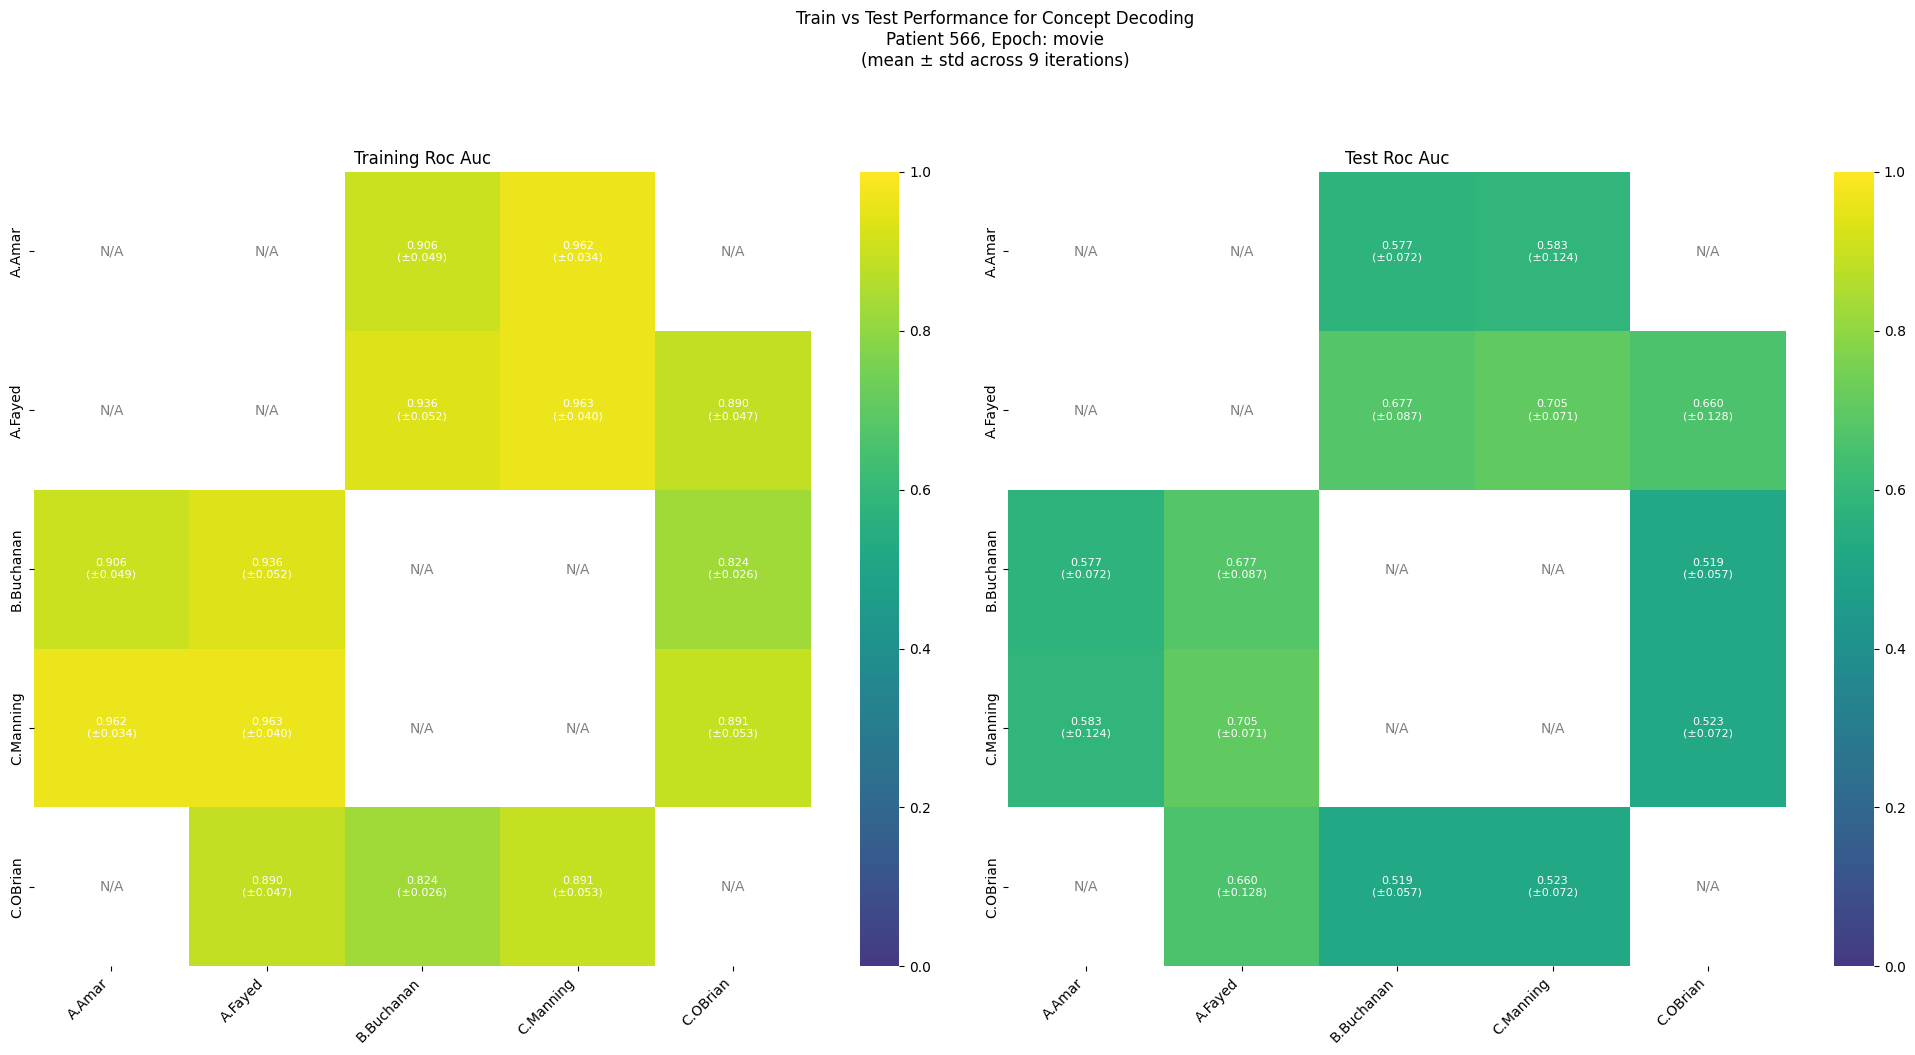

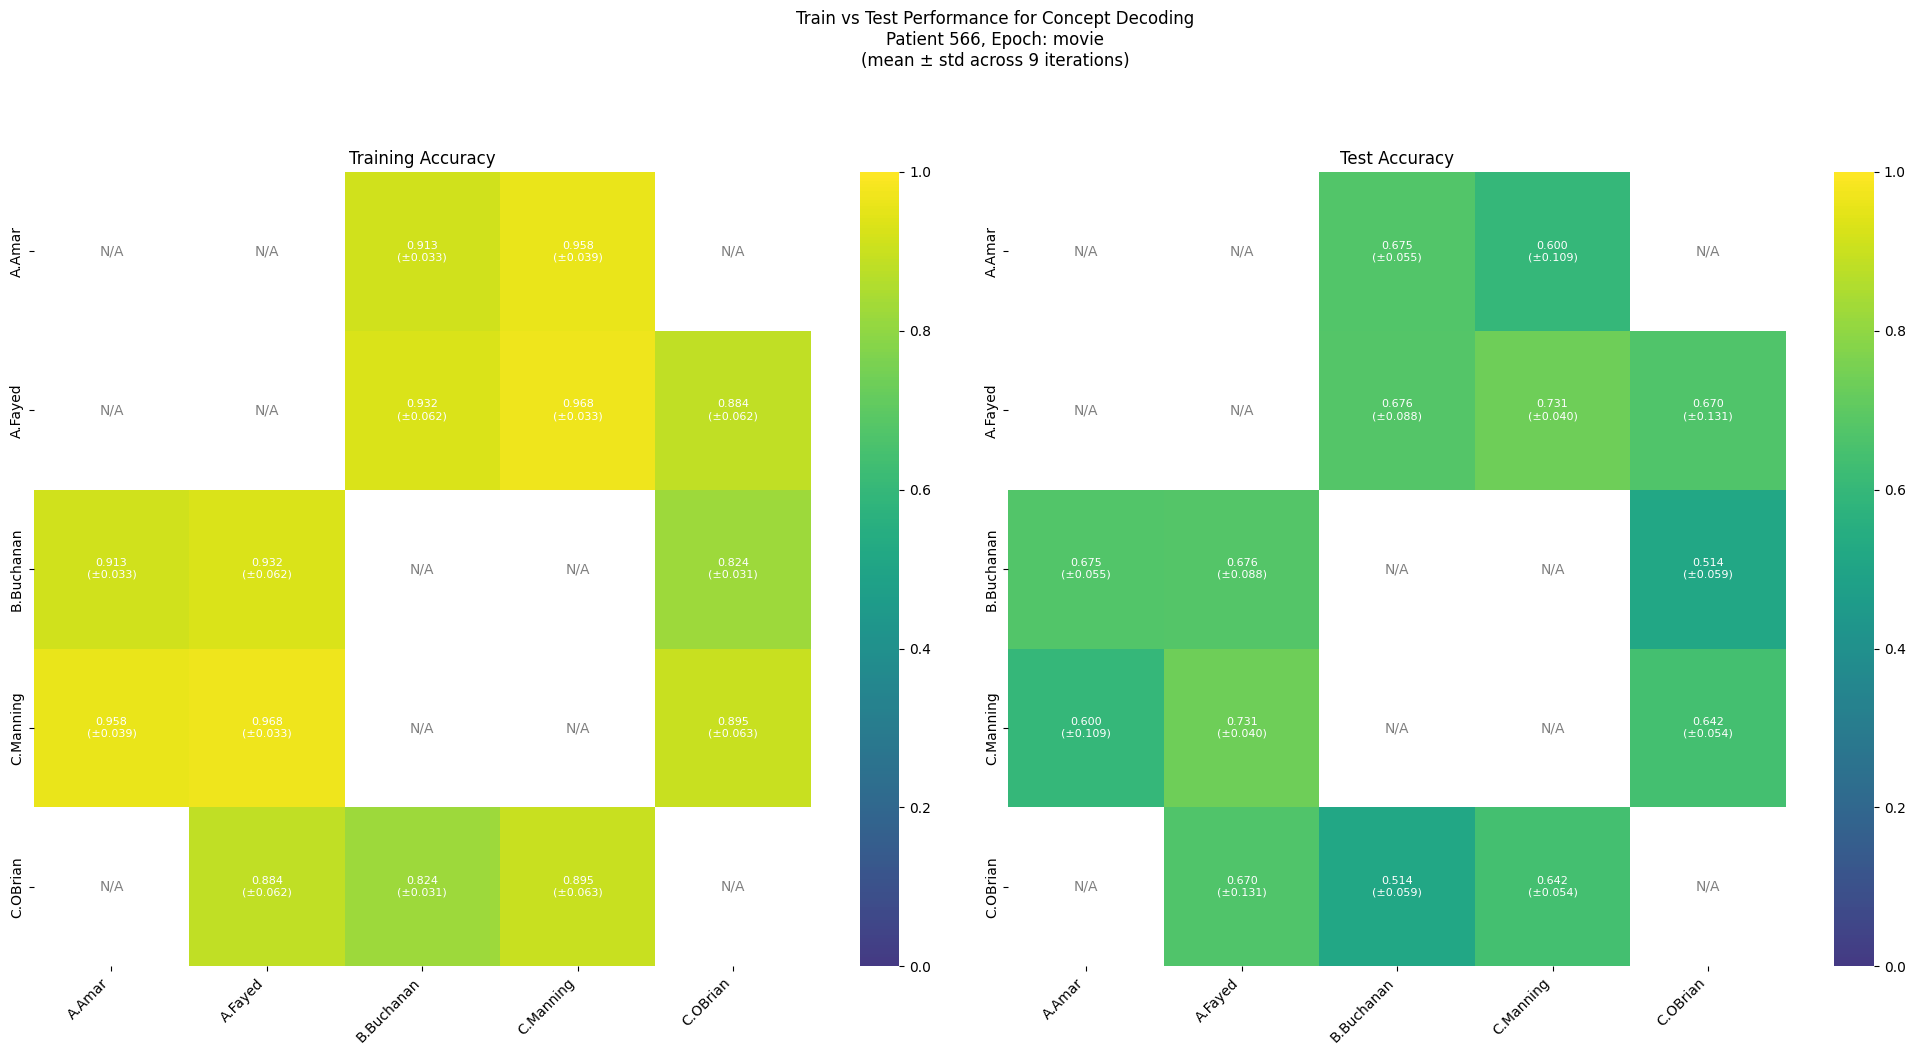

{'train_mean': array([[       nan,        nan, 0.91256831, 0.95833333,        nan],
        [       nan,        nan, 0.93194444, 0.96767677, 0.88378033],
        [0.91256831, 0.93194444,        nan,        nan, 0.8236715 ],
        [0.95833333, 0.96767677,        nan,        nan, 0.8952381 ],
        [       nan, 0.88378033, 0.8236715 , 0.8952381 ,        nan]]),
 'train_std': array([[       nan,        nan, 0.03278689, 0.0389756 ,        nan],
        [       nan,        nan, 0.06239188, 0.0329485 , 0.06235788],
        [0.03278689, 0.06239188,        nan,        nan, 0.03064874],
        [0.0389756 , 0.0329485 ,        nan,        nan, 0.06317381],
        [       nan, 0.06235788, 0.03064874, 0.06317381,        nan]]),
 'test_mean': array([[       nan,        nan, 0.67489712, 0.6       ,        nan],
        [       nan,        nan, 0.67619048, 0.73148148, 0.66959064],
        [0.67489712, 0.67619048,        nan,        nan, 0.51388889],
        [0.6       , 0.73148148,        nan,  

In [27]:
manager.plot_train_test_performance_heatmap(metric='test_roc_auc') # Example ROC AUC heatmap
manager.plot_train_test_performance_heatmap(metric='test_accuracy') # Example Accuracy heatmap